<a href="https://colab.research.google.com/github/annvorosh/GB/blob/ML_Med/ML_Med_L04_segm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Итоговое задание - выполнить СЕГМЕНТАЦИЮ полипов согласно приложенного датасета.
https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg

1. подготовить данные должным образом.
2. Попробовать различные архитектуры, выбрать наилучшую.
3. Попробовать аугментацию, трансферное обучение.
4. Визуализировать предсказания выбранной модели.
5. Составить обобщающий хороший вывод.
6. (по желанию) сделать API


https://habr.com/ru/companies/otus/articles/442918/ - как делать API для ML

Сдавать как обычно Гитхаб или Гугл колаб.

## Введение

Набор данных KvasirCapsule-SEG содержит изображения полипов, их истинные маски сегментации и информацию о ограничительной коробке. Для решения задачи сегментации полипов использовалась модель U-Net, которая является одной из самых популярных архитектур для задач сегментации.


## Загрузка библиотек

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras import layers
import zipfile

In [2]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Константы
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT)
CLASSES = 1
IMG_CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

## Загрузка и распаковка датасета

In [4]:
# Путь к файлу архива
zip_file_path = '/content/archive.zip'
extracted_dir_path = '/content/kvasir_capsule_seg'

# Распаковка архива
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [5]:
# Путь к папкам с изображениями и масками
extracted_dir_path = '/content/kvasir_capsule_seg'
images_dir = os.path.join(extracted_dir_path, 'Kvasir-Capsule/images')
masks_dir = os.path.join(extracted_dir_path, 'Kvasir-Capsule/masks')

# Получение списка файлов
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.jpg')])

# Создание датафрейма для удобства работы
data_df = pd.DataFrame({
    'image': [os.path.join(images_dir, f) for f in image_files],
    'mask': [os.path.join(masks_dir, f) for f in mask_files]
})

In [6]:
# Разделение на обучающую и тестовую выборки
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [7]:
# Загрузка данных
def load_data(df):
    images = []
    masks = []
    for _, row in df.iterrows():
        image = Image.open(row['image']).convert('RGB')
        mask = Image.open(row['mask']).convert('L')  # Черно-белое изображение
        image = np.array(image)
        mask = np.array(mask)
        if len(image.shape) == 2:  # Добавляем канал для черно-белых изображений
            image = np.expand_dims(image, axis=-1)
        if len(mask.shape) == 2:  # Добавляем канал для черно-белых масок
            mask = np.expand_dims(mask, axis=-1)
        image = tf.image.resize(image, IMG_SHAPE)
        mask = tf.image.resize(mask, IMG_SHAPE)
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)


X_train, Y_train = load_data(train_df)
X_test, Y_test_original = load_data(test_df)

## Нормализация данных
В случае изображений каждый пиксель представляет собой значение интенсивности, обычно в диапазоне от 0 до 255 для черно-белых изображений или от 0 до 255 для каждого канала (красного, зеленого и синего) для цветных изображений. Нормализация путем деления на 255 приводит все значения к диапазону от 0 до 1, что упрощает обучение модели.

In [8]:
# Подготовка данных для нейронной сети
X_train = X_train / 255.0
X_test = X_test / 255.0
Y_train = Y_train / 255.0
Y_test = Y_test_original / 255.0

## Функции предобработки и пост обработки данных

Преобразуем трехмерный массив (изображение с тремя каналами цвета) в двумерный массив, используя заданную палитру для преобразования цветов.

In [9]:
def convert_from_color(arr_3d, palette):
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    for c, i in palette.items():
        arr_2d[np.all(arr_3d == c, axis=-1)] = i
    return arr_2d

Преобразуем цвета в метки классов:
Каждый пиксель в маске сегментации имеет определенный цвет, который соответствует классу (фону или полипу).

In [10]:
def preprocess_masks(masks, num_classes):
    processed_masks = []
    palette = {
        (0, 0, 0): 0,        # Фон (чёрный)
        (255, 255, 255): 1   # Полип (белый)
    }
    for mask in masks:
        mask = mask[:, :, :3]  # Убираем альфа-канал, если он есть
        mask = convert_from_color(mask, palette)  # Преобразование цвета в метки классов
        mask = tf.keras.utils.to_categorical(mask, num_classes)
        processed_masks.append(mask)
    return np.array(processed_masks)


Y_train = preprocess_masks(Y_train, CLASSES)
Y_test = preprocess_masks(Y_test, CLASSES)


## Data augmentation
Аугментация данных - это процесс создания новых обучающих примеров путем применения случайных преобразований к существующим образцам. В контексте обработки изображений это может включать в себя вращение, отражение, сдвиг, изменение масштаба и другие трансформации, которые помогают сделать модель более устойчивой к вариациям данных и повысить ее обобщающую способность.

In [11]:
# Аугментация данных
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=32, seed=seed)
mask_generator = mask_datagen.flow(Y_train, batch_size=32, seed=seed)

train_generator = zip(image_generator, mask_generator)

## Объявление топологии нейронной сети, компиляция и обучение

In [12]:
# Определение модели U-Net с регуляризацией
def unet_model(image_size=(256, 256), output_classes=1):
    input_layer = Input(shape=image_size + (3,))

    # Encoder
    conv1 = Conv2D(32, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(input_layer)
    conv1_1 = Conv2D(128, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv1)
    conv2 = Conv2D(256, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv1_1)
    conv3 = Conv2D(512, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv2)
    conv4 = Conv2D(512, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv3)
    conv5 = Conv2D(512, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv4)
    conv6 = Conv2D(512, 4, activation=LeakyReLU(), strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv5)

    # Decoder
    up1 = Conv2DTranspose(512, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(conv6)
    up1 = Concatenate()([up1, conv5])
    up1 = BatchNormalization()(up1)
    up1 = Dropout(0.25)(up1)

    up2 = Conv2DTranspose(512, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(up1)
    up2 = Concatenate()([up2, conv4])
    up2 = BatchNormalization()(up2)
    up2 = Dropout(0.25)(up2)

    up3 = Conv2DTranspose(512, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(up2)
    up3 = Concatenate()([up3, conv3])
    up3 = BatchNormalization()(up3)
    up3 = Dropout(0.25)(up3)

    up4 = Conv2DTranspose(256, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(up3)
    up4 = Concatenate()([up4, conv2])
    up4 = BatchNormalization()(up4)

    up5 = Conv2DTranspose(128, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(up4)
    up5 = Concatenate()([up5, conv1_1])
    up5 = BatchNormalization()(up5)

    up6 = Conv2DTranspose(64, 4, activation='relu', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01), use_bias=False)(up5)
    up6 = Concatenate()([up6, conv1])
    up6 = BatchNormalization()(up6)

    # Output
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2, padding='same', kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))(up6)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [13]:
model = unet_model()

## Определим метрики для оценки качества модели в задачах сегментации, таких как U-Net.

**Dice Coefficient** (Коэффициент Сёренсена-Дайса):
Это метрика, которая измеряет сходство между двумя множествами (в данном случае, масками сегментации).

**Mean Intersection over Union** (Среднее значение пересечения по объединению):
Это метрика, которая вычисляет IoU (Intersection over Union) для каждого изображения в батче, а затем возвращает среднее значение по всем изображениям.

Обе метрики оценивают качество сегментации, основываясь на сравнении предсказанных и истинных масок.

In [14]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    iou = intersection / union
    return tf.reduce_mean(iou)



In [15]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient, mean_iou])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         1536      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 128)          65536     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 32, 32, 256)          524288    ['conv2d_1[0][0]']            
                                                                                              

## Обучение модели

### Early Stopping для остановки обучения при достижении плато на проверочной выборке

In [16]:
# Добавление метода ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=100, validation_data=(X_test, Y_test), callbacks=[early_stopping])


Epoch 1/100
1/1 [==============================] - 30s 30s/step - loss: 47.7503 - accuracy: 0.5015 - dice_coefficient: 0.6666 - mean_iou: 0.4999 - val_loss: 42.2695 - val_accuracy: 0.8140 - val_dice_coefficient: 0.6713 - val_mean_iou: 0.5052
Epoch 2/100
1/1 [==============================] - 7s 7s/step - loss: 42.4169 - accuracy: 0.4941 - dice_coefficient: 0.6671 - mean_iou: 0.5005 - val_loss: 37.6715 - val_accuracy: 0.5047 - val_dice_coefficient: 0.6654 - val_mean_iou: 0.4986
Epoch 3/100
1/1 [==============================] - 1s 938ms/step - loss: 37.7258 - accuracy: 0.5155 - dice_coefficient: 0.6712 - mean_iou: 0.5051 - val_loss: 33.6677 - val_accuracy: 0.6043 - val_dice_coefficient: 0.6706 - val_mean_iou: 0.5044
Epoch 4/100
1/1 [==============================] - 0s 430ms/step - loss: 33.7497 - accuracy: 0.5164 - dice_coefficient: 0.6724 - mean_iou: 0.5065 - val_loss: 30.1754 - val_accuracy: 0.8150 - val_dice_coefficient: 0.6723 - val_mean_iou: 0.5063
Epoch 5/100
1/1 [===============

## Визуализация потерь и метрики IoU модели

Оценим процесс обучения модели и проконтролируем, происходит ли переобучение (если потери на валидации начнут расти, а на обучении - падать) или недообучение (если потери на обучении и валидации остаются высокими). Также оценим эффективность модели с точки зрения среднего значения IoU.

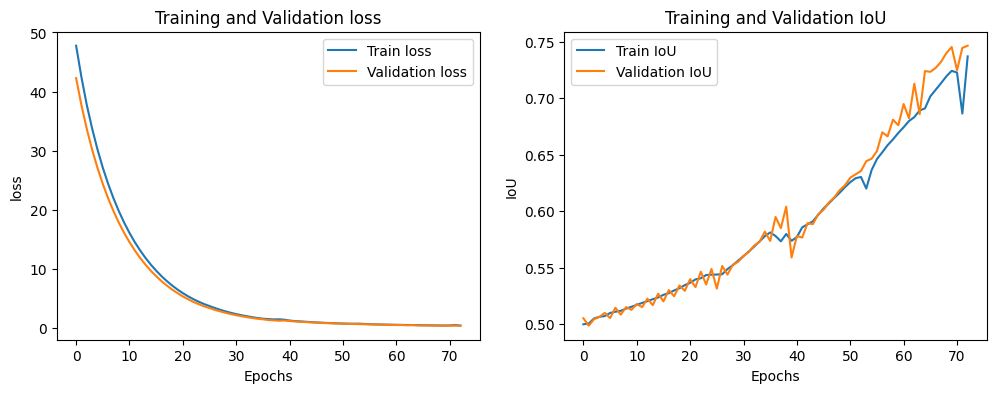

In [17]:
# Визуализация потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

# Визуализация mean_iou
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Train IoU')
plt.plot(history.history['val_mean_iou'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.show()

- Значения потерь последовательно уменьшаются с увеличением числа эпох, что свидетельствует о процессе обучения модели. При этом потери при валидации немного ниже, чем потери при обучении, что свидетельствует о хорошей обобщающей способности модели и отсутствии признаков переобучения.
- Потери на обучающей и валидационной выборках следуют схожей тенденции, при этом валидационные потери немного выше, но все же близки, что говорит о хорошей обобщающей способности модели.
- Небольшое увеличение потерь в конце может указывать на возможное переобучение или проблемы с скоростью обучения.


## Примеры предсказаний predict для нескольких тестовых картинок

In [18]:
# Прогнозирование для всех тестовых изображений
predictions = model.predict(X_test)

1/1 [==============================] - 0s 247ms/step


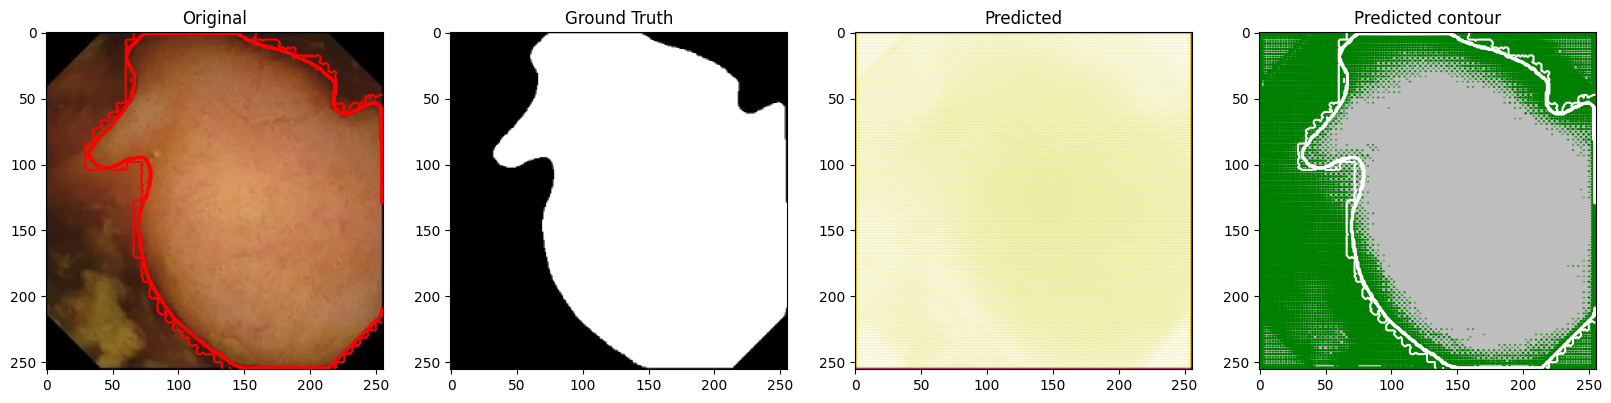

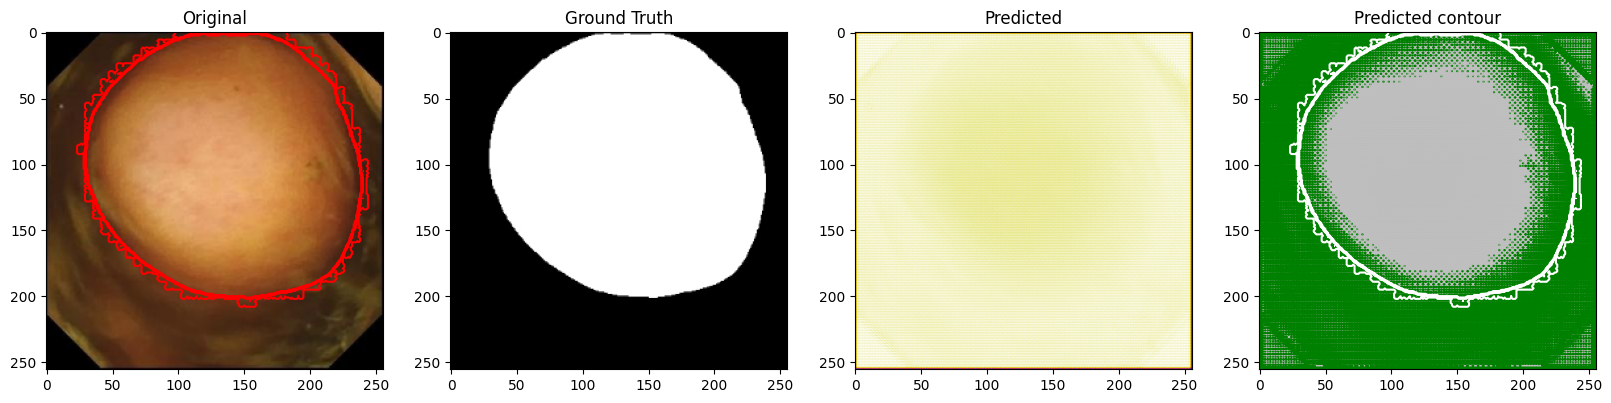

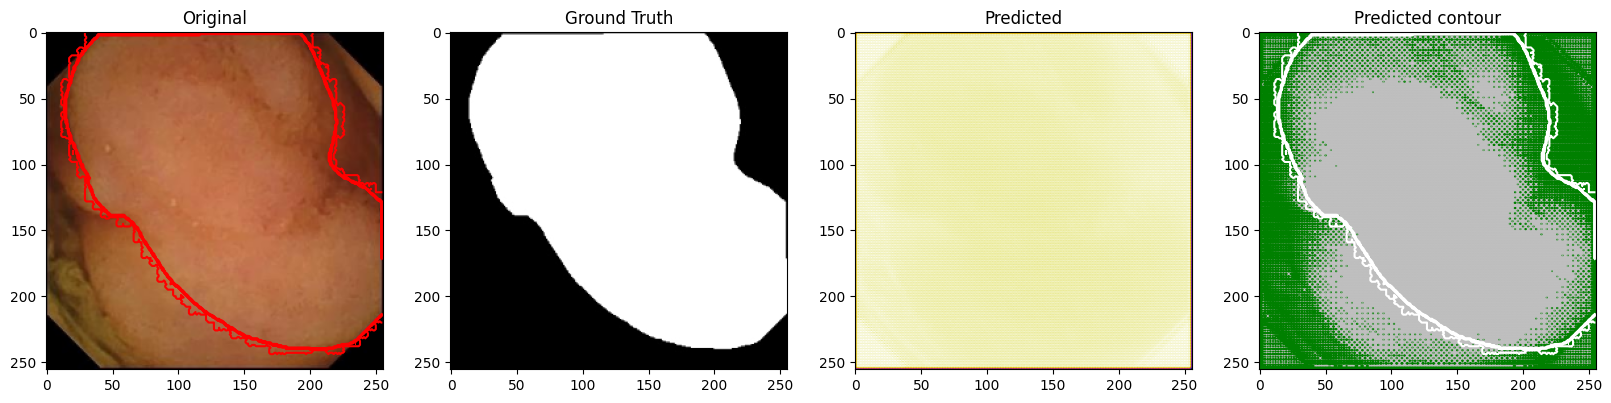

In [47]:
# Визуализация нескольких изображений
for i in range(3):
    ix = np.random.randint(0, len(X_test))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))

    # Оригинальное изображение с контуром Ground Truth
    ax[0].imshow(X_test[ix])
    ax[0].contour(Y_test_original[ix].squeeze(), colors='r')
    ax[0].set_title('Original')

    # Эталонная маска
    ax[1].imshow(Y_test_original[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')

    # Предсказанная маска
    ax[2].imshow(predictions[ix].squeeze(), cmap='CMRmap')
    ax[2].set_title('Predicted')

    # Предсказанная маска-контур
    ax[3].imshow(predictions[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[3].contour(predictions[ix].squeeze(), colors='g') # контур предсказанной маски зеленый
    ax[3].contour(Y_test_original[ix].squeeze(), colors='w') # контур оригинльной маски
    ax[3].set_title('Predicted contour')

    plt.show()


# Выбор отображения 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r'

1. Original — это оригинальное изображение с красными контурами, представляющими предсказанную сегментацию.

2. Ground Truth показывает эталонную маску сегментации, где целевая область обозначена желтым цветом.

3. Predicted отображает предсказанную маску сегментации.

4. Predicted contour отображает контур предсказанной маски (зеленый) и контур оригинальной маски (белый)



## Заключение

В этом проекте мы использовали модель U-Net для сегментации полипов на наборе данных KvasirCapsule-SEG. Модель была успешно обучена и продемонстрировала сегментацию на тестовых данных. При этом мы наблюдаем по контурам предсказанной маски, что какие-то закономерности в обнаружении полипов модель обнаруживает, но, конечно, неточно.